In [105]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle


In [73]:
df=pd.read_csv('../data/raw/XGBoost_train.csv')

df=df.drop("id" , axis=1)
type_mapping = {'L': 0, 'M': 1, 'H': 2}

df['Type_numeric'] = df['Type'].map(type_mapping)

df['Numeric_ID'] = df['Product ID'].str.extract('(\d+)')
df['Numeric_ID'] = pd.to_numeric(df['Numeric_ID'])

df=df.drop("Product ID" , axis=1)
df=df.drop("Type" , axis=1)

In [74]:
import pdpipe as pdp

target=df.loc[:,'Machine failure']
features=df.drop('Machine failure' , axis=1)

features_train, features_test, target_train, target_test= train_test_split(features , target,                                                          
                                                                            random_state = 42,
                                                                            test_size = 0.2 )

# Calculate normalized cross-tabulation
var = pd.crosstab(index=features_train["Numeric_ID"], columns='ratio', 
                  normalize='columns').sort_values(by='ratio', ascending=False)

# Print top 10 categories
print(var.index[:10])

# Replace categories beyond top 10 with 'other'
features_train.loc[~features_train["Numeric_ID"].isin(var.index[:10]), "Numeric_ID"] = 'other'
print(features_train["Numeric_ID"].unique())
# for test 

# Replace categories beyond top 10 with 'other'
features_test.loc[~features_test["Numeric_ID"].isin(var.index[:10]), "Numeric_ID"] = 'other'
print(features_test["Numeric_ID"].unique())

### Applying onehote encode to categorical features
features_train.loc[:,"Numeric_ID"]=features_train.loc[:,"Numeric_ID"].astype(str)
features_test.loc[:,"Numeric_ID"]=features_test.loc[:,"Numeric_ID"].astype(str)

onehot = pdp.OneHotEncode(['Numeric_ID'], drop_first=False)
features_train = onehot.fit_transform(features_train)
features_test = onehot.transform(features_test)

print(features_train.shape)
print(features_test.shape)



Index([53257, 49056, 54275, 53271, 53258, 48892, 53140, 48897, 48894, 53270], dtype='int64', name='Numeric_ID')
['other' 48892 49056 53140 53257 54275 53271 48894 53270 53258 48897]
[53271 'other' 53258 48894 48892 54275 53257 53270 48897 49056 53140]
(109143, 22)
(27286, 22)


In [22]:
features_train_copy=features_train.copy()
col_correlated= ['Air temperature [K]', 'Process temperature [K]']
pca=PCA(n_components=0.90)
pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , pca)])
pipe_std_pca.fit(features_train_copy.loc[:,col_correlated])
print('\033[1mas we know these features are highly correlated and we can apply dimensionality reduction\033[0m')
print('\033[1mas from this method for 0.95 of variance we get 2 components\033[0m')
print('n_components:',pca.n_components_)

as we know these features are highly correlated and we can apply dimensionality reduction
as from this method for 0.95 of variance we get 2 components
n_components: 1


In [75]:
### Applying pca
col_correlated= ['Air temperature [K]', 'Process temperature [K]']
drop_col=[]

keep_col = [col for col in features_train.columns if col not in col_correlated and col not in drop_col]

pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , PCA(n_components=0.9))])

col_dropper=ColumnTransformer([('pass_throu' , 'passthrough' , keep_col)] , remainder='drop')
corr_transformer=ColumnTransformer([('pipe_std_pca' , pipe_std_pca ,col_correlated )] , remainder=col_dropper)
col_names=['pca_0']+keep_col
features_train = pd.DataFrame(corr_transformer.fit_transform(features_train) , columns=col_names)
features_test = pd.DataFrame(corr_transformer.transform(features_test) , columns=col_names)
print(features_train.shape)
print(features_test.shape)

(109143, 21)
(27286, 21)


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8560165751669448


F1_rf:  0.8626444159178434
Precision_rf:  0.9853372434017595
Recall_rf:  0.7671232876712328


<Axes: >

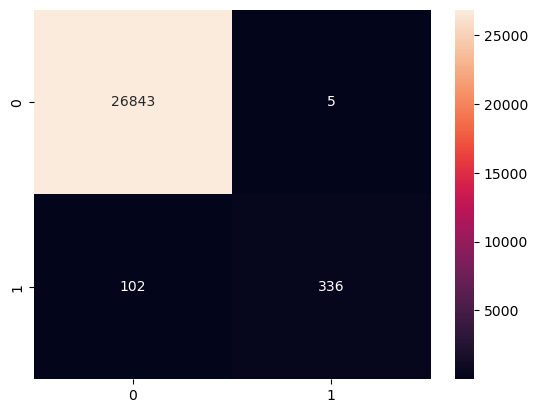

In [27]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized.best_estimator_)
print('rf_best_score_:',model_rf_optimized.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [30]:
####2
#f1_orig=f1_score(target_test, target_test_pred_optimized_rf)
#dict_importance=[]
#for col in features_test.columns:
#    features_test_perm=features_test.copy()
#    age_series_perm=features_test_perm.loc[:,col].sample(frac=1 , replace=False ,random_state=42 )
#    age_series_perm = age_series_perm.reset_index(drop=True)
#    features_test_perm.loc[:, col] = age_series_perm
#    target_test_pred_perm = model_rf_optimized.predict(features_test_perm)
#    f1_age = f1_score(target_test, target_test_pred_perm)
#    div=f1_orig - f1_age
#    dict_importance.append(div)
#perm_importances = pd.DataFrame(dict_importance , index=features_test.columns , columns=['Importance'])
#perm_importances=perm_importances.sort_values(by='Importance' , ascending=True)
#fig , ax =plt.subplots(figsize=(7,40))
#perm_importances.plot(kind='barh', ax=ax)

In [31]:
features_train['speed_power'] = features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) / (features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]'])
features_test['speed_power'] = features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) / (features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]'])

features_train['torque_power'] = features_train['Torque [Nm]'] / (features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]'])
features_test['torque_power'] = features_test['Torque [Nm]'] / (features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]'])


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8507272208002981


F1_rf:  0.8527131782945736
Precision_rf:  0.9821428571428571
Recall_rf:  0.7534246575342466


<Axes: >

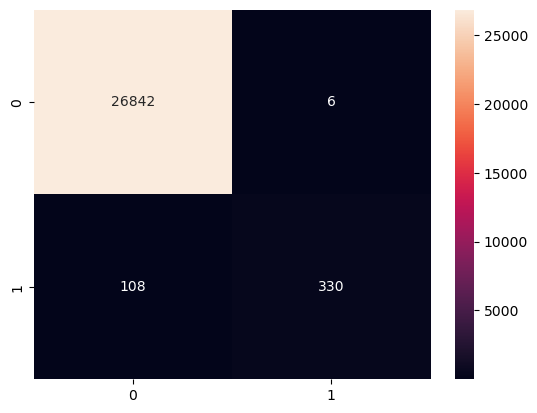

In [33]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_2=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_2.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_2.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_2.best_estimator_)
print('rf_best_score_:',model_rf_optimized_2.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [76]:
features_train['power'] =features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]']
features_test['power'] =features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]']


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8549224948102149


F1_rf:  0.8615384615384616
Precision_rf:  0.9824561403508771
Recall_rf:  0.7671232876712328


<Axes: >

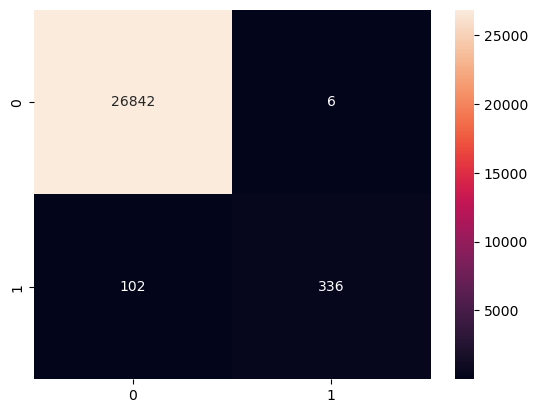

In [48]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_3=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_3.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_3.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_3.best_estimator_)
print('rf_best_score_:',model_rf_optimized_3.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

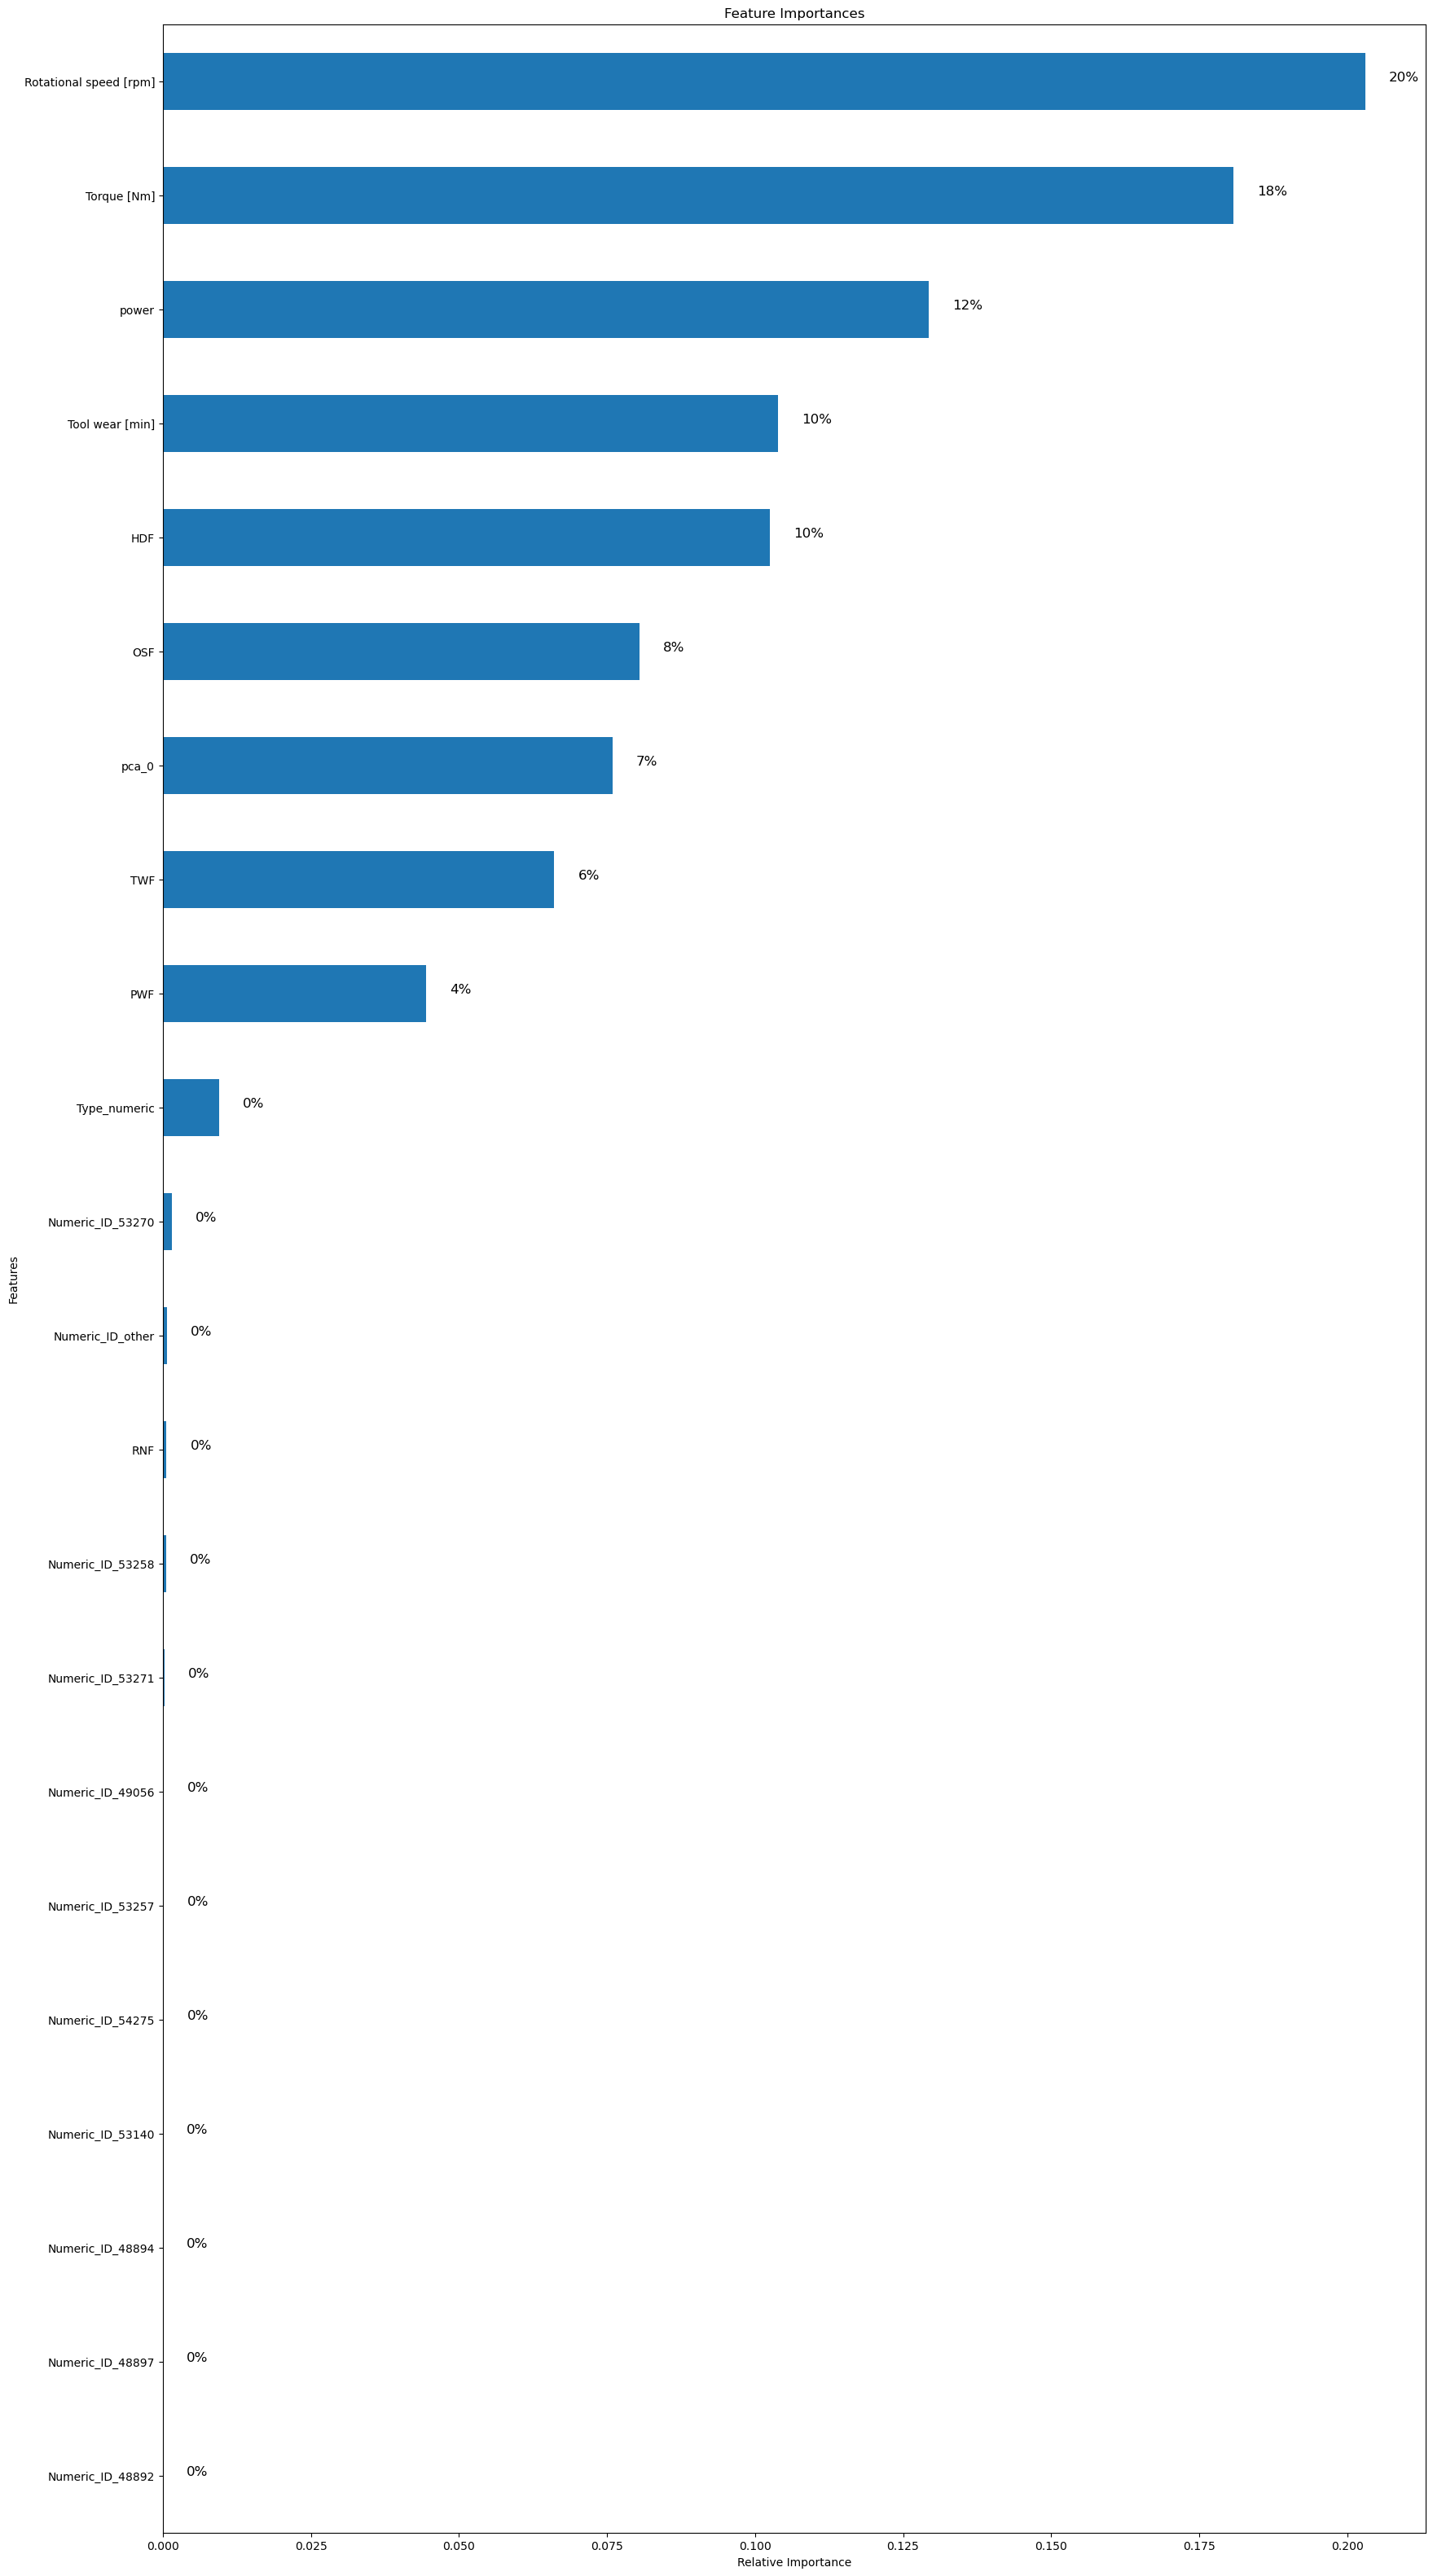

In [56]:
fig, ax = plt.subplots(figsize=(20, 40))

# Compute feature importances and sort them
feature_importance = pd.Series((model_rf_optimized_3.best_estimator_).feature_importances_,
                               index=features_train.columns).sort_values()

# Plotting horizontal bar chart for feature importances
feature_importance.plot(kind='barh', ax=ax, title='Feature Importances')
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Features')

# Adding text annotations for importance percentages
for idx in range(len(feature_importance.index)):
    ax.text(s='{}%'.format(int(100 * feature_importance.iloc[idx])),
            x=feature_importance.iloc[idx] + 0.004,
            y=idx,
            size=12,
            color='black')


In [109]:
pip install pdpbox


  Obtaining dependency information for pdpbox from https://files.pythonhosted.org/packages/1f/2e/8f115e0c514f2057fd8a99a01f52a5cd7d6952adf98dcffae086c2bccff6/PDPbox-0.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for sphinx-rtd-theme>=1.1.1 from https://files.pythonhosted.org/packages/ea/46/00fda84467815c29951a9c91e3ae7503c409ddad04373e7cfc78daad4300/sphinx_rtd_theme-2.0.0-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/121.1 kB ? eta -:--:--
     --------- --------------------------- 30.7/121.1 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 121.1/121.1 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/35.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/35.8 MB 2.2 MB/s eta 0:00:16
   ---------------------------------------- 0.2/35.8 MB 3.4 MB/s eta 0:00:11
   ---------------------------------------- 0.3/35.8 MB 2.8 MB/s eta 0:00:13
    -------------------------------------

In [119]:
pip install --upgrade pdpbox

Note: you may need to restart the kernel to use updated packages.


In [5]:
# pdp for Rotational_speed
from pdpbox import pdp


In [7]:
# pdp for Rotational_speed
from pdpbox import pdp_isolate, pdp_plot

pdp_Rotational_speed = pdp_isolate(model=model_rf_optimized_3, dataset=features_test,
                                   model_features=features_test.columns, feature='Rotational_speed')
pdp_plot(pdp_isolate_out=pdp_Rotational_speed, feature_name='Rotational_speed',
         plot_pts_dist=True, center=False)


ImportError: cannot import name 'pdp_isolate' from 'pdpbox' (C:\Users\Farnaz Ashrafi\anaconda3\Lib\site-packages\pdpbox\__init__.py)

In [54]:
features_train_copy=features_train.copy()
col_correlated= ['power', 'Torque [Nm]']
pca=PCA(n_components=0.97)
pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , pca)])
pipe_std_pca.fit(features_train_copy.loc[:,col_correlated])
print('\033[1mas we know these features are highly correlated and we can apply dimensionality reduction\033[0m')
print('\033[1mas from this method for 0.95 of variance we get 2 components\033[0m')
print('n_components:',pca.n_components_)

as we know these features are highly correlated and we can apply dimensionality reduction
as from this method for 0.95 of variance we get 2 components
n_components: 1


In [29]:
### Applying pca
col_correlated= ['power', 'Torque [Nm]']
drop_col=[]

keep_col = [col for col in features_train.columns if col not in col_correlated and col not in drop_col]

pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , PCA(n_components=0.9))])

col_dropper=ColumnTransformer([('pass_throu' , 'passthrough' , keep_col)] , remainder='drop')
corr_transformer=ColumnTransformer([('pipe_std_pca' , pipe_std_pca ,col_correlated )] , remainder=col_dropper)
col_names=['pca_1']+keep_col
features_train = pd.DataFrame(corr_transformer.fit_transform(features_train) , columns=col_names)
features_test = pd.DataFrame(corr_transformer.transform(features_test) , columns=col_names)
print(features_train.shape)
print(features_test.shape)

(109143, 21)
(27286, 21)


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8559804787471638


F1_rf:  0.8655569782330345
Precision_rf:  0.9854227405247813
Recall_rf:  0.771689497716895


<Axes: >

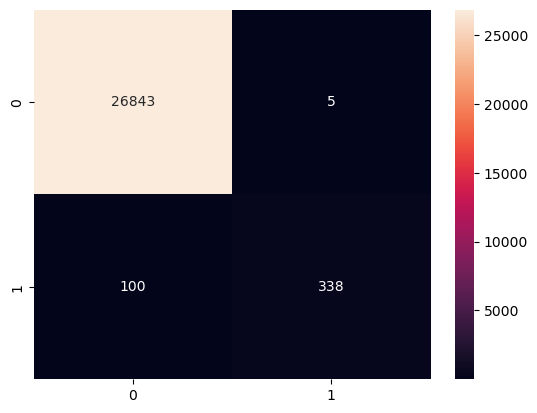

In [65]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_4=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_4.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_4.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_4.best_estimator_)
print('rf_best_score_:',model_rf_optimized_4.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

gridsearch_results_LinearSVC:
log_best_estimator_: Pipeline(steps=[('std', MinMaxScaler()),
                ('svc',
                 LinearSVC(C=0.01, class_weight='balanced', dual=False,
                           random_state=42))])
log_best_score_: 0.8238180183405396


F1_log:  0.8134777376654633
Precision_log:  0.8600508905852418
Recall_log:  0.771689497716895
roc_ouc:  0.8848204639955155


<Axes: >

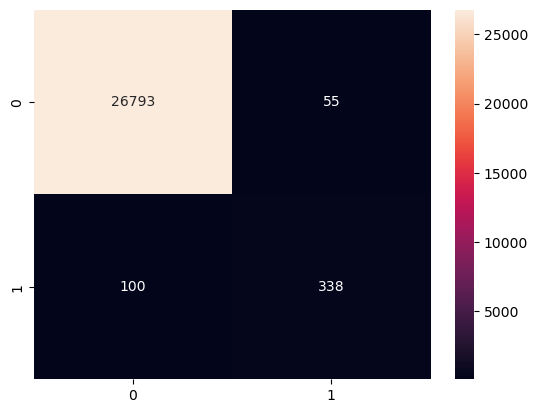

In [69]:
## algorithm : LinearSVC
# tune hyperparameters
svc = LinearSVC(dual=False, class_weight='balanced', random_state=42)
#svc=SVC(random_state=42)
pipeline_svc=Pipeline([('std' , MinMaxScaler()) ,('svc' , svc)])

search_space={'svc__C':[0.01 ,0.1 ,1 ,10 ,100] } # 'kernel':['linear' , 'poly' ,'rbf']

model_svm=GridSearchCV(estimator=pipeline_svc , param_grid=search_space , cv=5 , n_jobs=-1, scoring='f1')
model_svm.fit(features_train , target_train)
target_test_pred_optimized_svc=model_svm.predict(features_test)
print('gridsearch_results_LinearSVC:')
print('log_best_estimator_:',model_svm.best_estimator_)
print('log_best_score_:',model_svm.best_score_)
print('\n')
print('F1_log: ', f1_score(target_test, target_test_pred_optimized_svc))
print('Precision_log: ', precision_score(target_test, target_test_pred_optimized_svc))
print('Recall_log: ', recall_score(target_test, target_test_pred_optimized_svc))
print('roc_ouc: ', roc_auc_score(target_test, target_test_pred_optimized_svc))
confusion_matrix_svc_optimized= confusion_matrix(target_test, target_test_pred_optimized_svc)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

In [33]:
!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 640.0 kB/s eta 0:02:36
   ---------------------------------------- 0.0/99.8 MB 393.8 kB/s eta 0:04:14
   ---------------------------------------- 0.1/99.8 MB 1.2 MB/s eta 0:01:23
   ---------------------------------------- 0.3/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.4/99.8 MB 2.0 MB/s eta 0:00:51
   ---------------------------------------- 0.6/99.8 MB 2.3 MB/s eta 0:00:43
   ---------------------------------------- 0.7/99.8 MB 2.3 MB/s eta 0:00:43
   ---------------------------------------- 0.8/99.8 MB 2.6 MB/s eta 0:00:38
   --------------------------------

In [77]:
features_train.columns

Index(['pca_0', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Type_numeric', 'Numeric_ID_48892',
       'Numeric_ID_48894', 'Numeric_ID_48897', 'Numeric_ID_49056',
       'Numeric_ID_53140', 'Numeric_ID_53257', 'Numeric_ID_53258',
       'Numeric_ID_53270', 'Numeric_ID_53271', 'Numeric_ID_54275',
       'Numeric_ID_other', 'power'],
      dtype='object')

In [80]:
features_train.rename(columns={
    "Rotational speed [rpm]": "Rotational_speed",
    "Torque [Nm]": "Torque",
    "Tool wear [min]" : "Tool_wear"}, inplace=True)

features_test.rename(columns={
    "Rotational speed [rpm]": "Rotational_speed",
    "Torque [Nm]": "Torque",
    "Tool wear [min]" :"Tool_wear"}, inplace=True)


In [81]:
for col in features_train.columns:
    features_train[col] = pd.to_numeric(features_train[col], errors='coerce')        
    features_test[col] = pd.to_numeric(features_test[col], errors='coerce')


Accuracy 0.9961518727552591
F1_log:  0.8659003831417625
Precision_log:  0.9826086956521739
Recall_log:  0.773972602739726
roc_ouc:  0.8868745612029977


<Axes: >

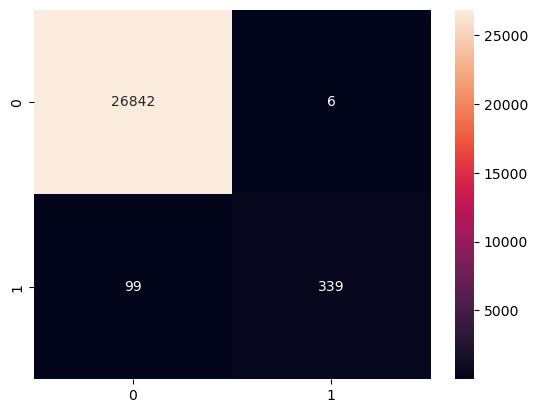

In [63]:
from xgboost import XGBClassifier

# Instantiate XGBClassifier
model_XGB= XGBClassifier()

# Fit the model to the training data
model_XGB.fit(features_train, target_train)

# Make predictions on the test set
predictions_XGB = model_XGB.predict(features_test)

# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

Accuracy 0.9960785750934545
F1_log:  0.8636942675159236
Precision_log:  0.9769452449567724
Recall_log:  0.773972602739726
roc_ouc:  0.8868373144807092


<Axes: >

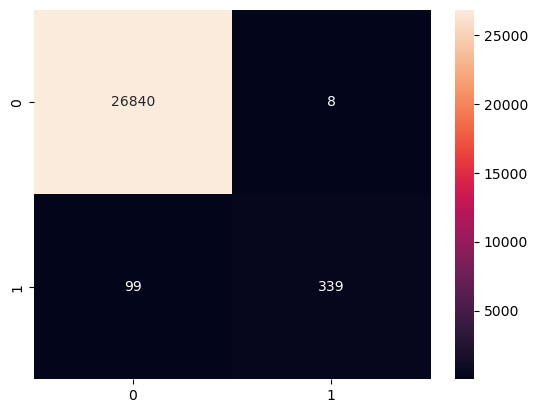

In [92]:
# without pca for power
from xgboost import XGBClassifier

# Instantiate XGBClassifier
model_XGB= XGBClassifier()

# Fit the model to the training data
model_XGB.fit(features_train, target_train)

# Make predictions on the test set
predictions_XGB = model_XGB.predict(features_test)

# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

Accuracy 0.9961518727552591
F1_log:  0.8659003831417625
Precision_log:  0.9826086956521739
Recall_log:  0.773972602739726
roc_ouc:  0.8868745612029977


<Axes: >

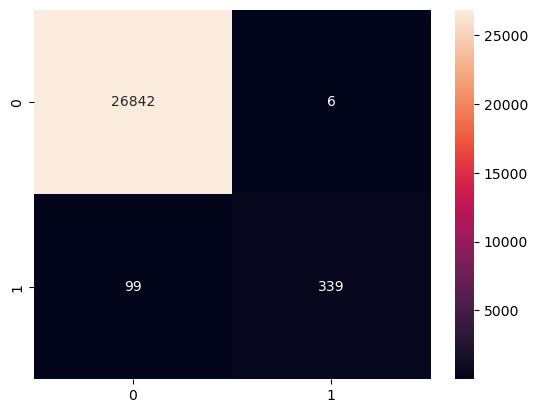

In [72]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve


xgb = XGBClassifier(n_estimators=1000, 
                    eval_metric='f1', 
                    random_state=42, 
                    )

# Make predictions on the test set
predictions_XGB = xgb.predict(features_test)

# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

Accuracy 0.9960785750934545
F1_log:  0.8636942675159236
Precision_log:  0.9769452449567724
Recall_log:  0.773972602739726
roc_ouc:  0.8868373144807092


<Axes: >

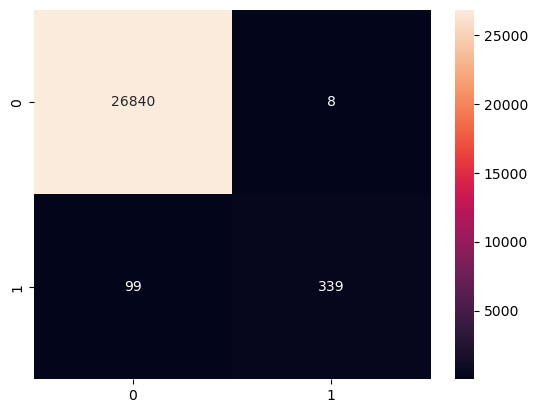

In [94]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

# Assuming 'features_train' and 'target_train' are your training features and target
# Train an XGBoost classifier
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(features_train, target_train)

# Make predictions on the test set
predictions_XGB = xgb.predict(features_test)


# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

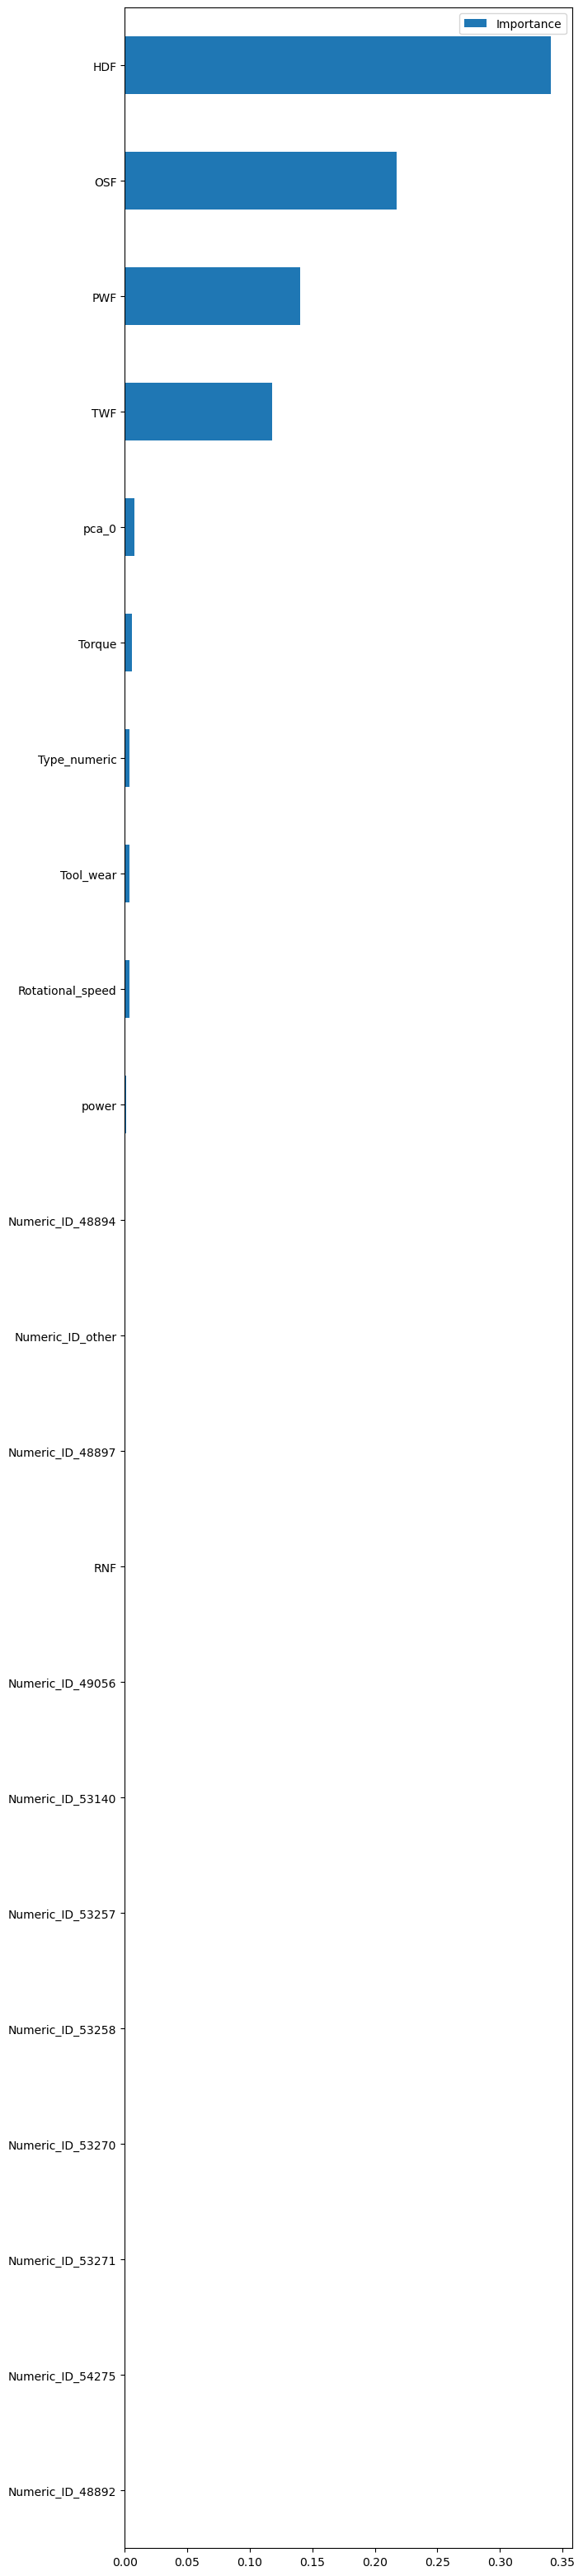

In [88]:
f1_orig = f1_score(target_test, model_XGB.predict(features_test))
dict_importance = []

for col in features_test.columns:
    features_test_perm = features_test.copy()
    col_values_perm = features_test_perm.loc[:, col].sample(frac=1, replace=False, random_state=42)
    col_values_perm = col_values_perm.reset_index(drop=True)
    features_test_perm.loc[:, col] = col_values_perm
    target_test_pred_perm = model_XGB.predict(features_test_perm)
    f1_perm = f1_score(target_test, target_test_pred_perm)
    div = f1_orig - f1_perm
    dict_importance.append(div)

perm_importances = pd.DataFrame(dict_importance, index=features_test.columns, columns=['Importance'])
perm_importances = perm_importances.sort_values(by='Importance', ascending=True)

fig, ax = plt.subplots(figsize=(7, 40))
perm_importances.plot(kind='barh', ax=ax)
plt.show()

In [97]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Assuming 'features_train' and 'target_train' are your training features and target
# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the F1 scorer
f1_scorer = make_scorer(f1_score)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10,50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7 ,25],
    # Add more hyperparameters as needed
}

# Initialize GridSearchCV with the F1 scorer
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=f1_scorer, cv=5)

# Perform grid search on the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions_XGB = best_model.predict(features_test)

# Calculate F1 score on the test set
f1_orig = f1_score(target_test, predictions_XGB)
print(f"F1 Score on the original test set: {f1_orig}")


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
F1 Score on the original test set: 0.8637532133676092


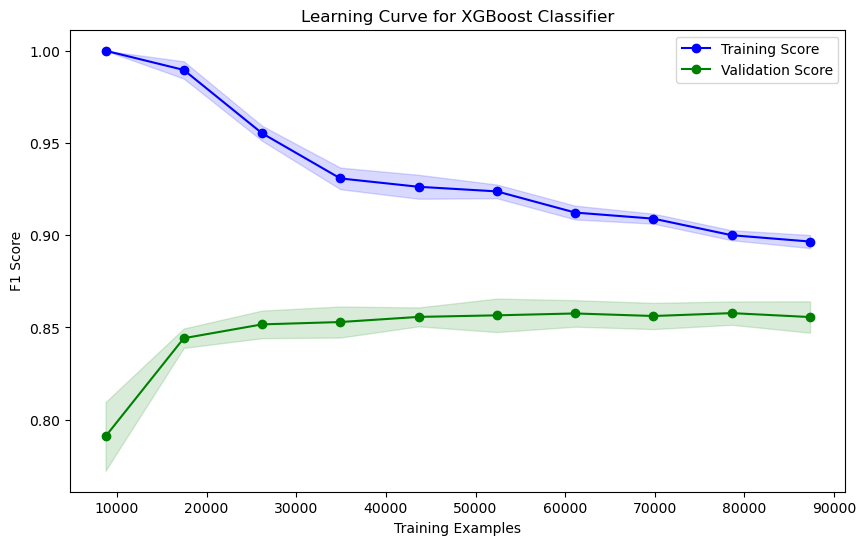

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
from xgboost import XGBClassifier

# Assuming 'features_train' and 'target_train' are your training features and target
# Create an XGBoost classifier
xgb = XGBClassifier(n_estimators=50, random_state=42)

# Define the training sizes (percentages of the dataset)
train_sizes, train_scores, valid_scores = learning_curve(
    XGBClassifier(n_estimators=100, random_state=42),
    features_train, target_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Adjust the range as needed
    scoring='f1',  # Use the F1 score as the evaluation metric
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Calculate mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, valid_mean, label='Validation Score', color='green', marker='o')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='green')
plt.title('Learning Curve for XGBoost Classifier')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


Average of f1_scor for cross_val_score: 0.5953257143241858 [0.62202043 0.58669575 0.60869565 0.58429319 0.57492355]
f1_scor_train: 0.5885810243492863
f1_scor: 0.5929565929565929
recall_score: 0.8264840182648402
precison_score: 0.4623243933588761
roc_auc_score: 0.9054015740907038


<Axes: >

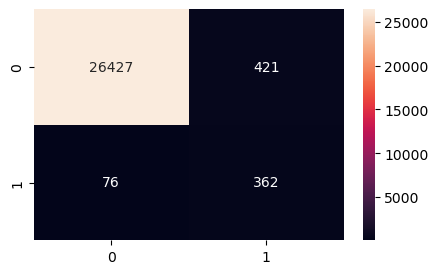

In [102]:
model_log_base=LogisticRegression(class_weight='balanced' , random_state=42 , max_iter=10000)
pipeline_log_base=Pipeline([('std' , MinMaxScaler() ), ('model' ,model_log_base)])
pipeline_log_base.fit(features_train , target_train)

result_log_unoptimized=cross_val_score(estimator=pipeline_log_base , X=features_train , y=target_train,
                                       cv=5 , scoring='f1')
print('Average of f1_scor for cross_val_score:',result_log_unoptimized.mean() , result_log_unoptimized)



# predict and evaluate on test set
target_test_pred_base=pipeline_log_base.predict(features_test)

target_train_pred_base=pipeline_log_base.predict(features_train)
print('f1_scor_train:',f1_score(target_train, target_train_pred_base))


print('f1_scor:',f1_score(target_test, target_test_pred_base))
print('recall_score:',recall_score(target_test, target_test_pred_base))
print('precison_score:',precision_score(target_test, target_test_pred_base))
print('roc_auc_score:',roc_auc_score(target_test, target_test_pred_base))
confusion_matrix_log_base = confusion_matrix(target_test, target_test_pred_base)
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix_log_base, annot=True, fmt='d')

F1_log:  0.8575129533678756
Precision_log:  0.9910179640718563
Recall_log:  0.7557077625570776
roc_ouc:  0.8777980111951061


<Axes: >

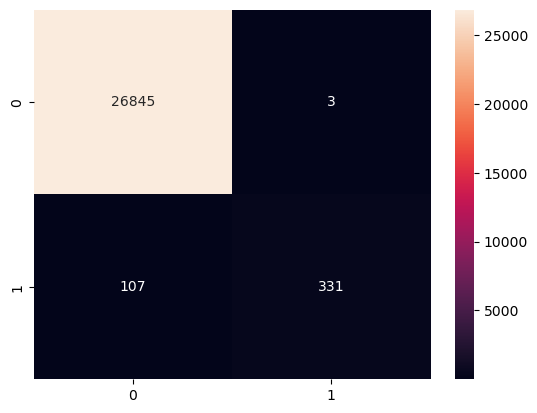

In [107]:
#### build model
## algorithm : KNeighborsClassifier
pipeline_knn=Pipeline([('std' , StandardScaler()),('knn' , KNeighborsClassifier())])
pipeline_knn.fit(features_train , target_train)
# predict and evaluate on test set
target_test_pred_knn=pipeline_knn.predict(features_test)
print('F1_log: ', f1_score(target_test, target_test_pred_knn))
print('Precision_log: ', precision_score(target_test, target_test_pred_knn))
print('Recall_log: ', recall_score(target_test, target_test_pred_knn))
print('roc_ouc: ', roc_auc_score(target_test, target_test_pred_knn))
confusion_matrix_knn= confusion_matrix(target_test, target_test_pred_knn)
sns.heatmap(confusion_matrix_knn, annot=True, fmt='d')